<a href="https://colab.research.google.com/github/galalqassas/xai/blob/main/notebooks/Logistic%20Regression/Tasneem_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model : Binary Logistic Regression**
> ***Reference:***

> *ResearchGate, “Factors of employee attrition: A logistic
 regression
 approach,”
 May 1, 2023. [Online]. Available:
 https://www.researchgate.net/publication/373896134 Factors of
 Employee Attrition : A Logistic Regression Approach*

Take a copy of this notebook for each model you will implement.

This is the initial notebook — any changes will be made here before starting model building to ensure consistency across all notebooks.

**Key Consistency Tips**

* Standardized Headings: Use identical section names across all notebooks.

* Code Comments: Explain non-trivial steps (e.g., "Handling class imbalance with SMOTE").

* Version Control: Add a requirements.txt in the repo for dependency management. مش لازم

* Outputs: Save all plots/figures to a /results folder with consistent naming (e.g., XGBoost_SHAP.png).
اعتقد هتبقى كويسة عشان واحنا بنعمل البيبر ما نقعدش ناخد سكرينات


* Reproducibility: Set global random seeds (e.g., np.random.seed(42)).

# **Imports**

In [1]:
%%capture
!pip install -q lime shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc, PrecisionRecallDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import shap
import warnings
import os
warnings.filterwarnings('ignore')

#random seed for reproducibility
np.random.seed(42)

In [3]:
if not os.path.exists('results'):
    os.makedirs('results')

# **Utils**

In [4]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f'results/{name}_confusion_matrix.png')
    plt.show()
    plt.close()

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(model, X_train, y_train, name=name, ax=ax1, color="orange")
    roc2 = RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=ax2, color="orange")
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)
    plt.savefig(f'results/{name}_roc_curve.png')
    plt.show()
    plt.close()

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )
    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)
    plt.savefig(f'results/{name}_learning_curve.png')
    plt.show()
    plt.close()

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')
    plt.savefig(f'results/{name}_precision_recall_curve.png')
    plt.show()
    plt.close()

# **Load Processed Dat**a

In [5]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

Age  BusinessTravel  DailyRate  Department  DistanceFromHome  Education  \
0      31               2       1062           1                24          3   
1      50               2        328           1                 1          3   
2      46               2        717           1                13          4   
3      44               2        170           1                 1          4   
4      26               1       1479           1                 1          3   
...   ...             ...        ...         ...               ...        ...   
2042   56               2       1162           1                24          2   
2043   46               2        669           2                 9          2   
2044   30               2       1240           0                 9          3   
2045   31               2        741           1                 2          4   
2046   31               2        670           1                26          1   

      EducationField  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0                  3                        3       0          96  ...   
1                  3                        3       1          86  ...   
2                  1                        3       1          34  ...   
3                  1                        2       1          78  ...   
4                  1                        3       0          84  ...   
...              ...                      ...     ...         ...  ...   
2042               1                        1       1          97  ...   
2043               3                        3       1          64  ...   
2044               0                        3       1          48  ...   
2045               1                        2       1          69  ...   
2046               1                        1       1          31  ...   

      WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                   3            10.0                   9   
1                   2             3.0                   2   
2                   3            10.0                   7   
3                   3             2.0                   0   
4                   1             6.0                   5   
...               ...             ...                 ...   
2042                3             4.0                   2   
2043                3             9.0                   8   
2044                1            11.0                   9   
2045                4             5.0                   2   
2046                2             5.0                   2   

      YearsSinceLastPromotion  YearsWithCurrManager  promotion_velocity  \
0                           1                     8            9.999900   
1                           0                     2       300000.000000   
2                           0                     9      1000000.000000   
3                           2                     2            0.999995   
4                           1                     4            5.999940   
...                       ...                   ...                 ...   
2042                        1                     0            3.999960   
2043                        4                     7            2.249994   
2044                        4                     7            2.749993   
2045                        0                     3       500000.000000   
2046                        4                     3            1.249997   

      workload_score  compensation_ratio  Attrition    Set  
0                  1            1.019760          0  Train  
1                  2            1.281918          0  Train  
2                  1            0.832635          0  Train  
3                  1            0.753443          0  Train  
4                  3            1.007878          0  Train  
...              ...                 ...        ...    ...  
2042               1            0.898732          1   Test  
2043               1  

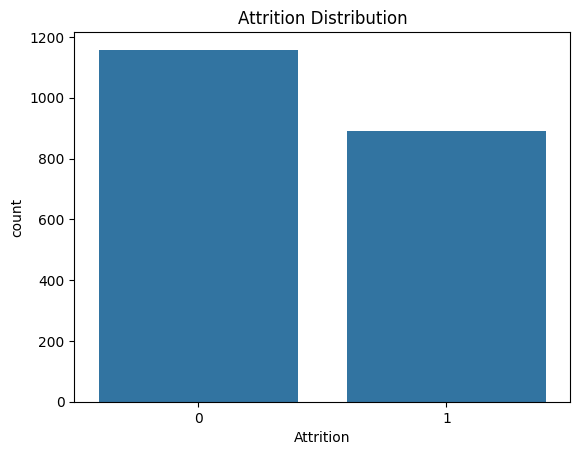

In [6]:
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

In [7]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Model-Specific EDA (Optional)**
According to Chen (2023), I analyzed some categorical and numerical features


<Figure size 1000x600 with 0 Axes>

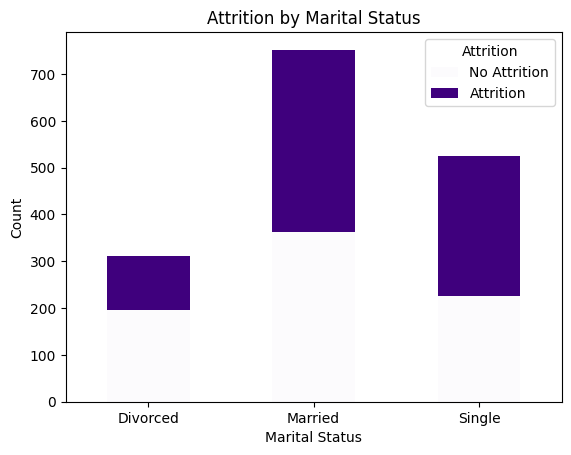

In [8]:
plt.figure(figsize=(10, 6))

train_df['MaritalStatus_Labeled'] = train_df['MaritalStatus'].map({0: 'Divorced', 1: 'Married', 2: 'Single'})
marital_counts = train_df.groupby(['MaritalStatus_Labeled', 'Attrition']).size().unstack()

marital_counts.plot(kind='bar', stacked=True, cmap='Purples')
plt.title('Attrition by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Attrition', labels=['No Attrition', 'Attrition'])
plt.xticks(rotation=0)
plt.savefig('results/logistic_regression_marital_status_stacked_bar.png')
plt.show()
plt.close()

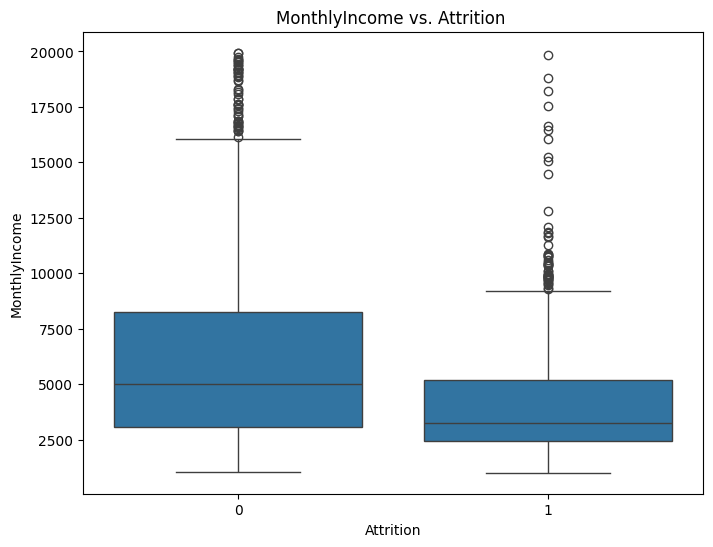

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=train_df)
plt.title('MonthlyIncome vs. Attrition ')
plt.savefig('results/logistic_regression_monthly_income_boxplot.png')
plt.show()

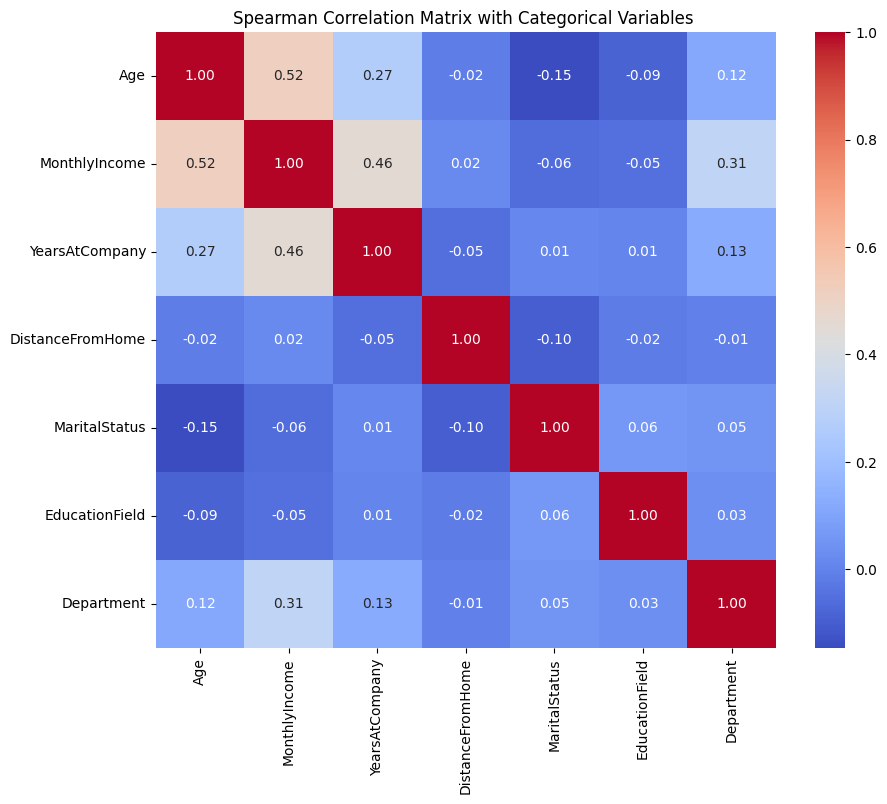

In [10]:
# Spearman corr (with both num & categotical cols)
cat_cols = ['MaritalStatus', 'EducationField', 'Department']
num_cols = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'DistanceFromHome']
spearman_data = train_df[num_cols + cat_cols]
spearman_corr = spearman_data.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Spearman Correlation Matrix with Categorical Variables ')
plt.savefig('results/logistic_regression_spearman_corr.png')
plt.show()
plt.close()

# **Model Initialization**

In [11]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# **Model Training**

In [12]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# **Model Evaluation**

In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy:.4f}")

accuracy: 0.7620


In [14]:
print(classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition']))

              precision    recall  f1-score   support

No Attrition       0.90      0.80      0.85       373
   Attrition       0.40      0.60      0.48        85

    accuracy                           0.76       458
   macro avg       0.65      0.70      0.66       458
weighted avg       0.81      0.76      0.78       458



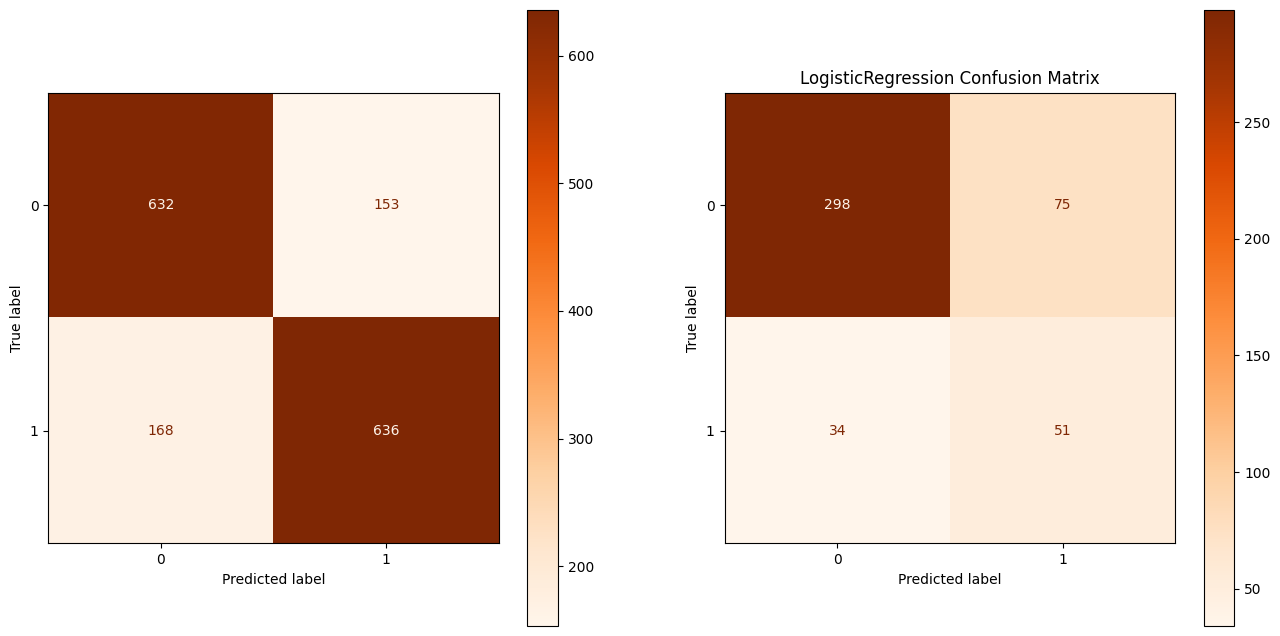

In [15]:
our_confusion_matrix(model, 'LogisticRegression')

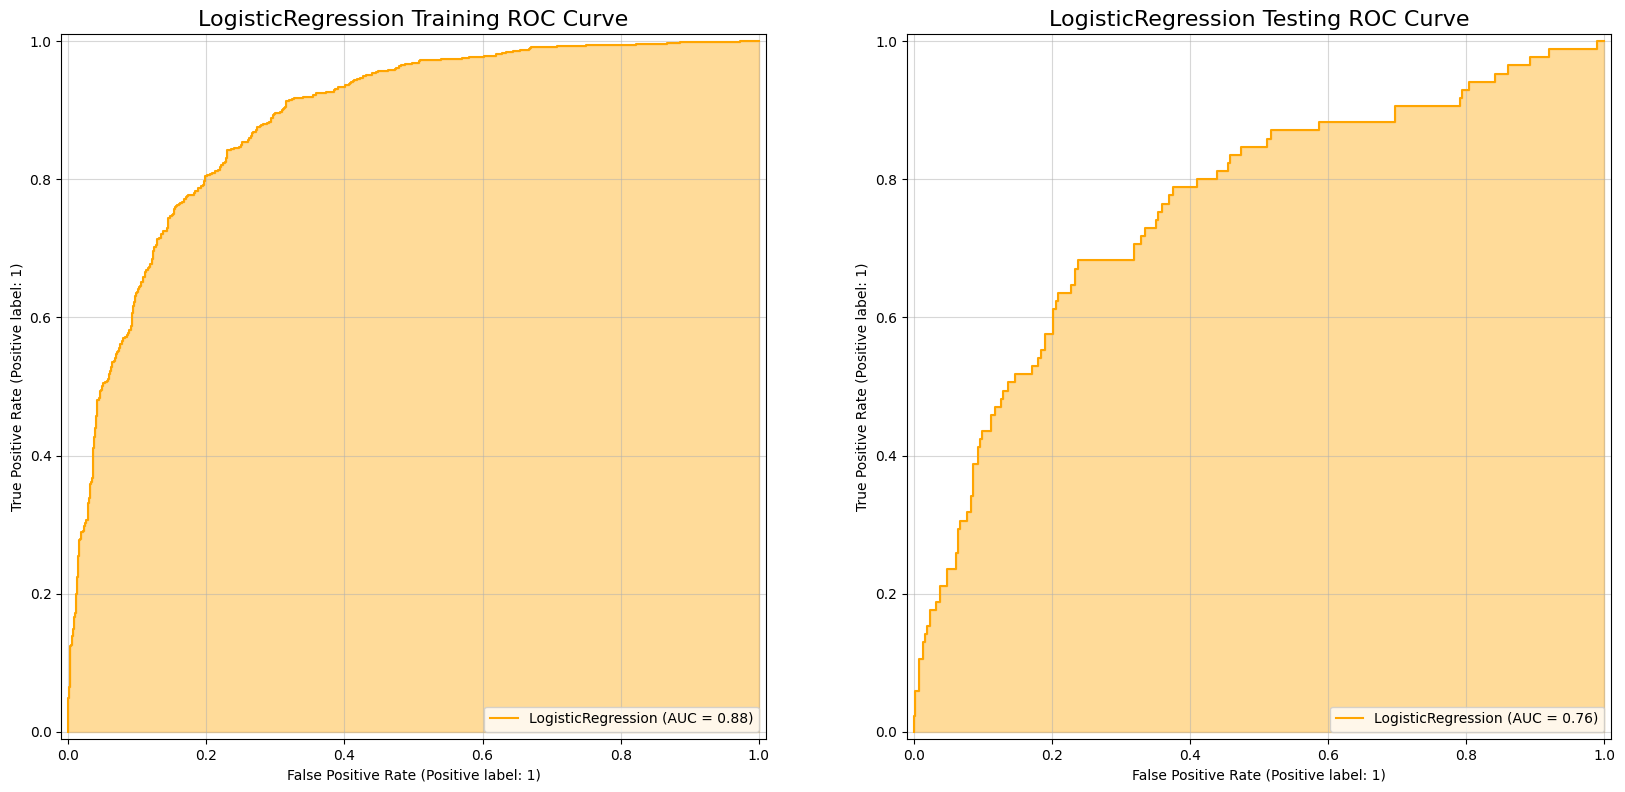

In [16]:
our_roc(model, 'LogisticRegression')

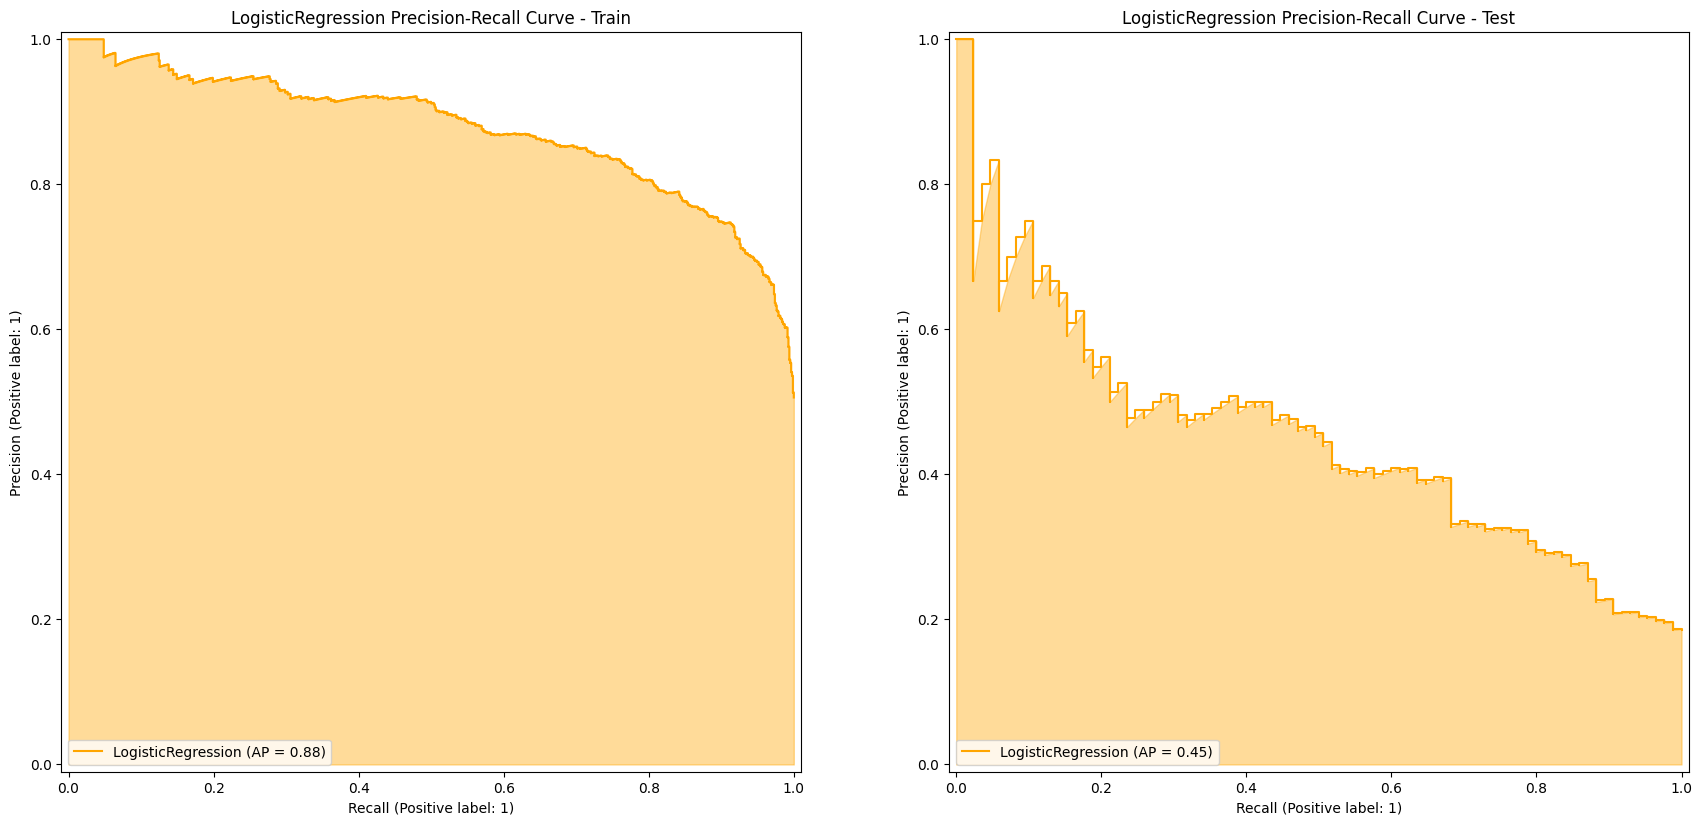

In [17]:
our_prc(model, 'LogisticRegression')

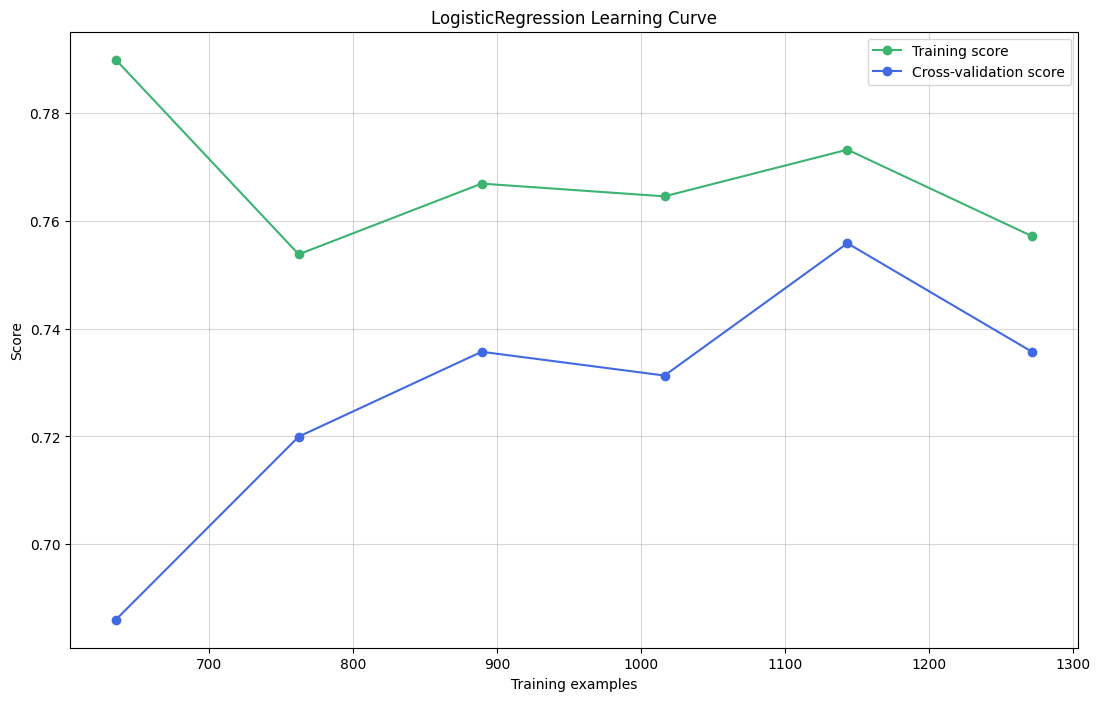

In [18]:
our_learning_curve(model, 'LogisticRegression')

<Figure size 640x480 with 0 Axes>

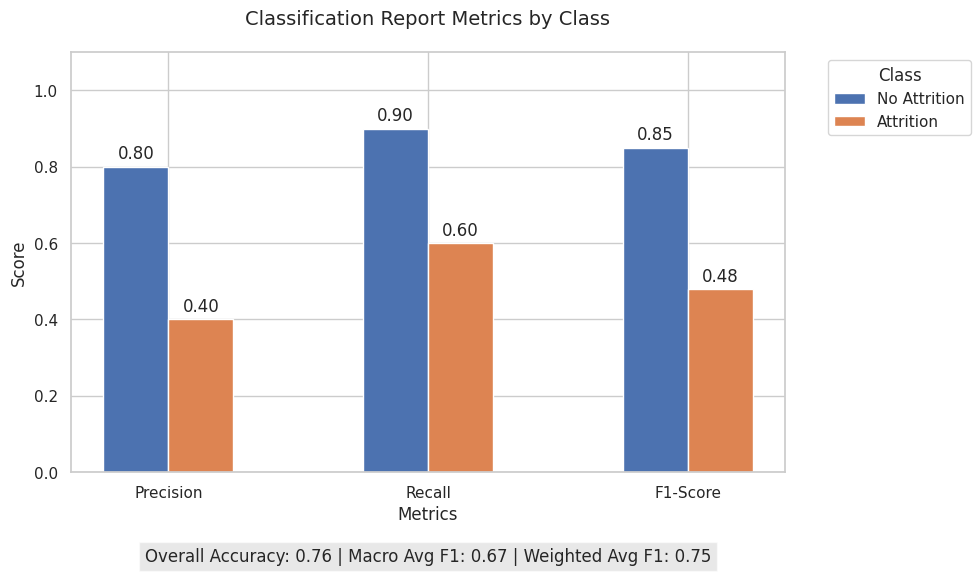

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data derived from test set confusion matrix
metrics = ['Precision', 'Recall', 'F1-Score']
classes = ['No Attrition', 'Attrition']
values = np.array([
    [0.80, 0.90, 0.85],  # No Attrition
    [0.40, 0.60, 0.48]   # Attrition
])

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

bar_width = 0.25
index = np.arange(len(metrics))

for i, class_name in enumerate(classes):
    plt.bar(index + i * bar_width, values[i], bar_width, label=class_name)

# text annotations
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        plt.text(j + i * bar_width, values[i][j] + 0.01,
                 f"{values[i][j]:.2f}",
                 ha='center', va='bottom')

plt.title('Classification Report Metrics by Class', fontsize=14, pad=20)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(index + bar_width / 2, metrics)
plt.ylim(0, 1.1)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add accuracy
plt.text(0.5, -0.2,
         f"Overall Accuracy: 0.76 | Macro Avg F1: 0.67 | Weighted Avg F1: 0.75",
         ha='center', va='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig('results/logistic_regression_classification_report.png')
plt.show()
plt.close()

###***Following Chen(2023)'s methodology, statistical tests were conducted while evaluating : “Omnibus and Hosmer-Lemeshow tests” to confirm the model significance and fit***

In [20]:
import statsmodels.api as sm
from scipy import stats

X_train_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_const).fit(disp=0)

# Omnibus Test
omnibus_p = logit_model.llr_pvalue
print("\nOmnibus Test of Model Coefficients:")
print(f"p-value: {omnibus_p:.4f}")
print("Model is significant (p < 0.05)" if omnibus_p < 0.05 else "Model is not significant (p >= 0.05)")


Omnibus Test of Model Coefficients:
p-value: 0.0000
Model is significant (p < 0.05)


The extremely low p-value (< 0.05) indicates the model is statistically significant, meaning at least one predictor significantly contributes to explaining attrition.

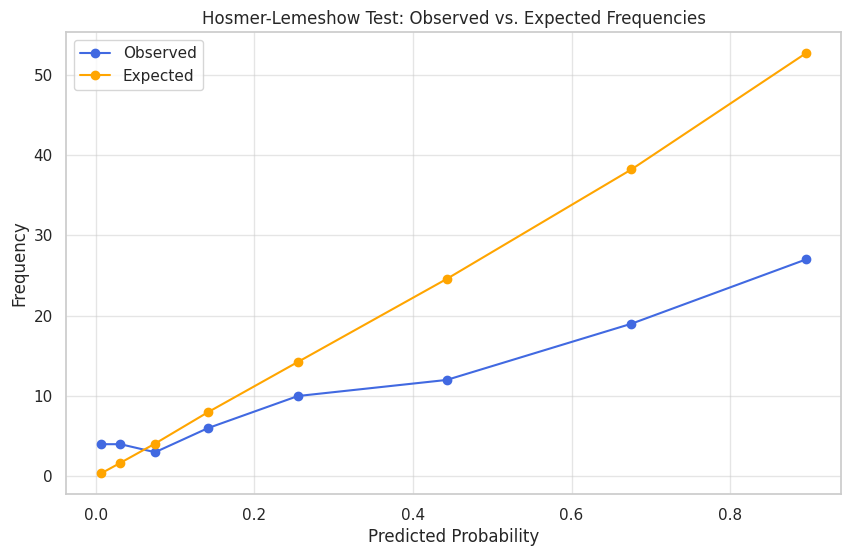


Hosmer-Lemeshow Goodness-of-Fit Test:
Statistic: 217.3734, p-value: 0.0000
Poor fit (p < 0.05)


In [21]:
# Hosmer-Lemeshow Test
def hosmer_lemeshow_test(y_true, y_pred_proba, groups=8):
  data = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred_proba})
  data['group'] = pd.qcut(data['y_pred'], groups, duplicates='drop')
  grouped = data.groupby('group').agg({'y_true': ['sum', 'count'], 'y_pred': 'mean'})
  observed = grouped['y_true']['sum']
  expected = grouped['y_true']['count'] * grouped['y_pred']['mean']
  hl_stat = ((observed - expected) ** 2 / (expected * (1 - grouped['y_pred']['mean']))).sum()
  p_value = 1 - stats.chi2.cdf(hl_stat, groups - 2)

  plt.figure(figsize=(10, 6))
  plt.plot(grouped.index.categories.mid, observed, 'o-', label='Observed', color='royalblue')
  plt.plot(grouped.index.categories.mid, expected, 'o-', label='Expected', color='orange')
  plt.title('Hosmer-Lemeshow Test: Observed vs. Expected Frequencies')
  plt.xlabel('Predicted Probability')
  plt.ylabel('Frequency')
  plt.legend()
  plt.grid(alpha=0.5)
  plt.savefig('results/logistic_regression_hosmer_lemeshow_diagnostic.png')
  plt.show()
  plt.close()

  return hl_stat, p_value


y_pred_proba = model.predict_proba(X_test)[:, 1]
hl_stat, hl_p = hosmer_lemeshow_test(y_test, y_pred_proba)
if hl_stat is not None:
    print("\nHosmer-Lemeshow Goodness-of-Fit Test:")
    print(f"Statistic: {hl_stat:.4f}, p-value: {hl_p:.4f}")
    print("Good fit (p >= 0.05)" if hl_p >= 0.05 else "Poor fit (p < 0.05)")

- The Hosmer-Lemeshow test yields a statistic of 217.4, a large value indicating a deviation between observed and expected frequencies.
- The p-value of 0.0000 (p < 0.05) confirms poor goodness of fit, consistent with Chen’s (2023) threshold, meaning the model’s predicted probabilities do not align well with actual outcomes.
- This is possibly influenced by preprocessing steps we have done to our data like the ADASYN oversampling.

In [22]:
# save res (for the paper)
stats_results = pd.DataFrame({
    'Test': ['Omnibus Test', 'Hosmer-Lemeshow Test'],
    'Statistic': ['N/A', hl_stat],
    'p-value': [omnibus_p, hl_p]
})
stats_results

Test   Statistic        p-value
0          Omnibus Test         N/A  2.249348e-235
1  Hosmer-Lemeshow Test  217.373445   0.000000e+00

## **Logistic Regression Assumptions Check:**

In [23]:
def check_multicollinearity(X):

    """ Checks for assumption 3: Multicollinearity using VIF (Variance Inflation Factor) """

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print("Assumption 3: Multicollinearity Check (VIF)")
    print(vif_data)
    print("\n")

    # if VIF > 10, then --> multicollinearity
    multicollinearity_issues = vif_data[vif_data["VIF"] > 10]
    if not multicollinearity_issues.empty:
        print("The following features have high multicollinearity (VIF > 10):")
        print(multicollinearity_issues)
    else:
        print("No significant multicollinearity detected (VIF < 10).")

In [24]:
def check_outliers(X):
    """ Checks for assumption 4 : Extreme Outliers using Z-scores. """
    z_scores = np.abs(zscore(X))
    outlier_threshold = 3
    outliers = (z_scores > outlier_threshold).sum(axis=0)

    print("\nAssumption 4: Extreme Outliers Check (Z-scores)")
    if any(outliers > 0):
        print("The following features have extreme outliers (Z-score > 3):")
        for i, feature in enumerate(X.columns):
            if outliers[i] > 0:
                print(f"{feature} - {outliers[i]} outliers")
    else:
        print("No extreme outliers detected (Z-score <= 3).")

In [25]:
check_multicollinearity(X_train)

Assumption 3: Multicollinearity Check (VIF)
                     feature         VIF
0                        Age   34.176790
1             BusinessTravel    6.837593
2                  DailyRate    5.836791
3                 Department   12.466895
4           DistanceFromHome    2.600782
5                  Education    9.759429
6             EducationField    4.041163
7    EnvironmentSatisfaction    7.033035
8                     Gender    2.194483
9                 HourlyRate   13.199078
10            JobInvolvement   13.872552
11                  JobLevel   37.966112
12                   JobRole    9.288638
13           JobSatisfaction    6.745885
14             MaritalStatus    5.479054
15             MonthlyIncome   24.736915
16               MonthlyRate    5.483371
17        NumCompaniesWorked    2.865483
18                  OverTime    6.828800
19         PercentSalaryHike   37.032619
20         PerformanceRating  128.419282
21  RelationshipSatisfaction    7.153877
22          S

In [26]:
check_outliers(X_train)


Assumption 4: Extreme Outliers Check (Z-scores)
The following features have extreme outliers (Z-score > 3):
JobLevel - 30 outliers
MonthlyIncome - 44 outliers
PerformanceRating - 155 outliers
StockOptionLevel - 48 outliers
TotalWorkingYears - 25 outliers
YearsAtCompany - 33 outliers
YearsInCurrentRole - 12 outliers
YearsSinceLastPromotion - 32 outliers
YearsWithCurrManager - 7 outliers
promotion_velocity - 41 outliers
compensation_ratio - 19 outliers


# **Explainability Techniques**

## LIME Analysis

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Attrition', 'Attrition'],
    mode='classification'
)

exp = explainer.explain_instance(
    X_test.iloc[0],
    model.predict_proba,
    num_features=13
)
exp.show_in_notebook(show_table=True)


<Figure size 1000x600 with 0 Axes>

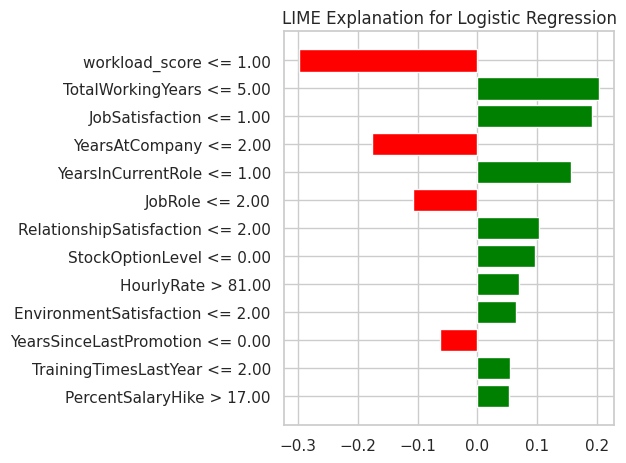

In [28]:
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title('LIME Explanation for Logistic Regression')
plt.tight_layout()
plt.savefig('results/logistic_regression_lime_bar.png')
plt.show()
plt.close()

**LIME Interpretation**

The LIME plot shows `workload_score` (+1.00) and `TotalWorkingYears` (+5.00) as strong positive contributors to "Attrition" (0.72 probability), while `YearsAtCompany` (-1.10) and `JobRole` (-0.54) reduce it. Features like `HourlyRate` (+0.35) have minor effects, indicating workload and experience drive the prediction.

## SHAP Analysis

In [29]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")

shap_values = explainer.shap_values(X_test)

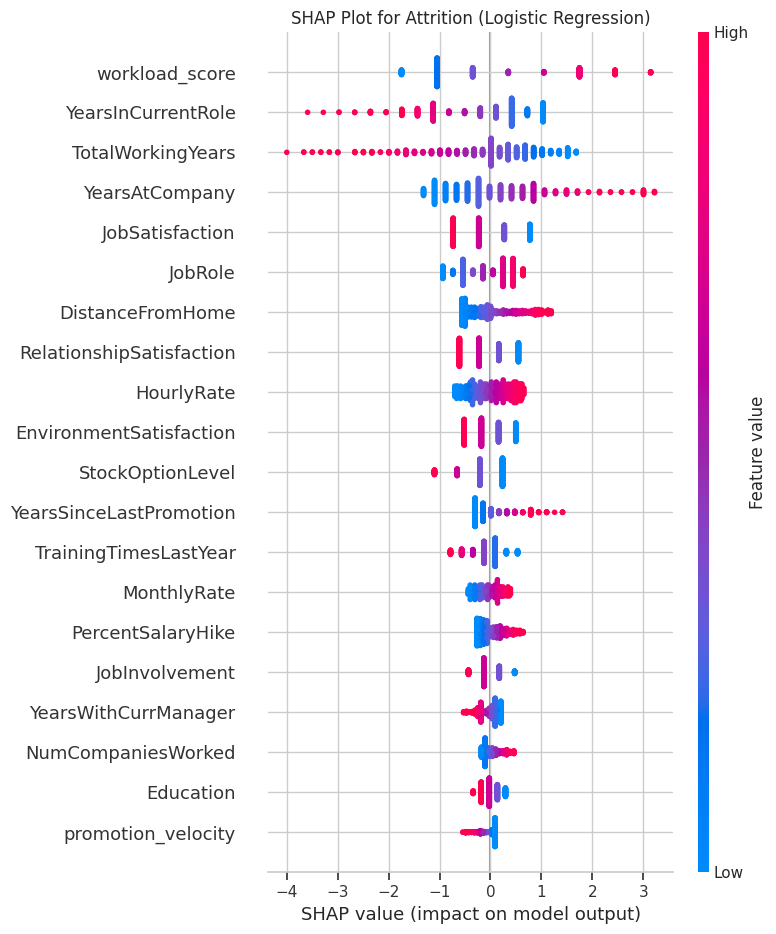

In [30]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Plot for Attrition (Logistic Regression)")
plt.tight_layout()
plt.savefig("results/logistic_regression_shap_summary.png")
plt.show()

The SHAP plot highlights `workload_score` as the top feature increasing "Attrition" probability (positive SHAP values), followed by `YearsInCurrentRole` and `TotalWorkingYears`. Features like `JobSatisfaction` and `DistanceFromHome` show mixed impacts, while `promotion_velocity` has minimal influence, showing that workload is a predictor tooo

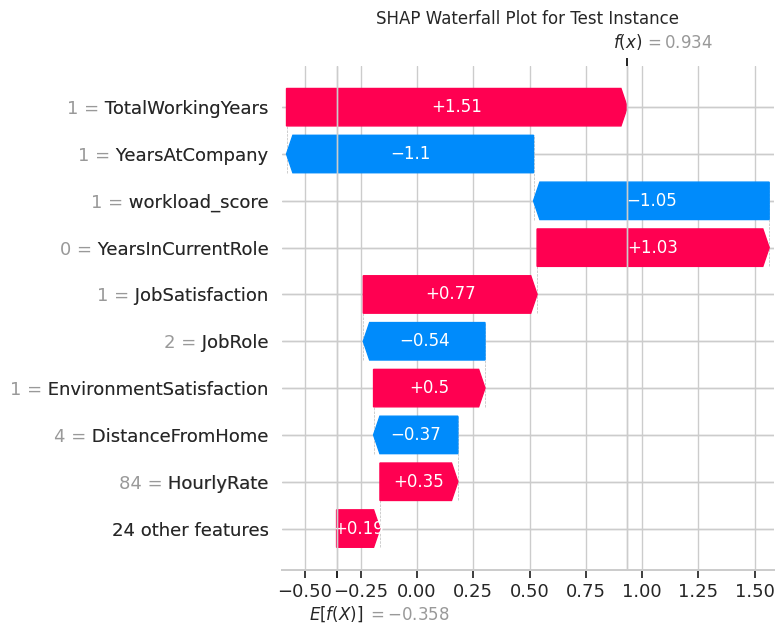

In [31]:
## Waterfall plot ##
instance_idx= 0
shap_value = explainer.shap_values(np.array(X_test)[instance_idx])

shap_values_exp = shap.Explanation(
    values=shap_value,
    base_values=explainer.expected_value,
    data=np.array(X_test)[instance_idx],
    feature_names=X_train.columns
)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_exp, max_display=10, show=False)
plt.title(f"SHAP Waterfall Plot for Test Instance")
plt.tight_layout()
plt.savefig('results/logistic_regression_shap_waterfall.png')
plt.show()


The waterfall plot for an instance (f(x) = 0.934) shows `TotalWorkingYears` (+1.51) and `JobSatisfaction` (+0.77) strongly push toward "Attrition," while `YearsAtCompany` (-1.10) and `workload_score` (-1.05) oppose it. Other features, like the HourlyRate have smaller effects, balancing to a high attrition

#### Dependence plot for top feature


In [32]:
shap_values_all = explainer.shap_values(X_test)
mean_abs_shap = np.abs(shap_values_all).mean(axis=0)

feature_names = X_train.columns
top_feature_index = np.argmax(mean_abs_shap) # the top feature
top_feature_name = feature_names[top_feature_index]

print(f"Top feature by SHAP value: {top_feature_name}")

Top feature by SHAP value: workload_score


<Figure size 1000x600 with 0 Axes>

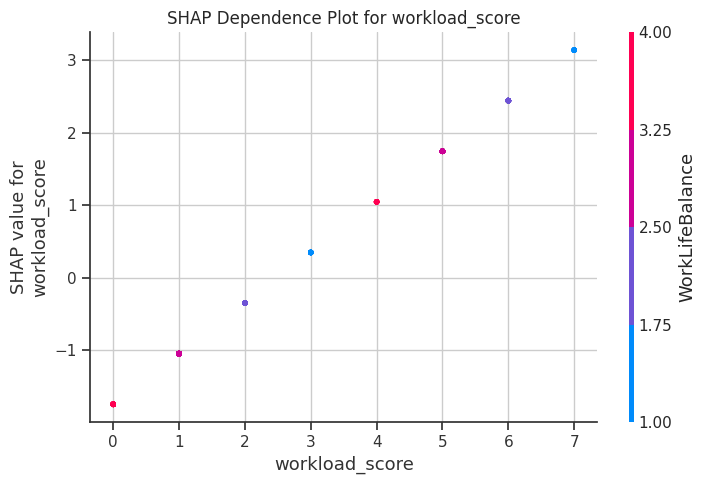

In [33]:
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature_name,
    shap_values_all,
    X_test,
    feature_names=feature_names,
    show=False
)
plt.title(f"SHAP Dependence Plot for {top_feature_name}")
plt.tight_layout()
plt.show()

The dependence plot shows `workload_score`’s SHAP value increases with higher scores (e.g., 6-7), indicating higher workloads strongly predict "Attrition."

Lower scores (0-2) show negative or neutral impacts, showing  a clear workload-attrition link.

## Feature Importance (Model-Specific)

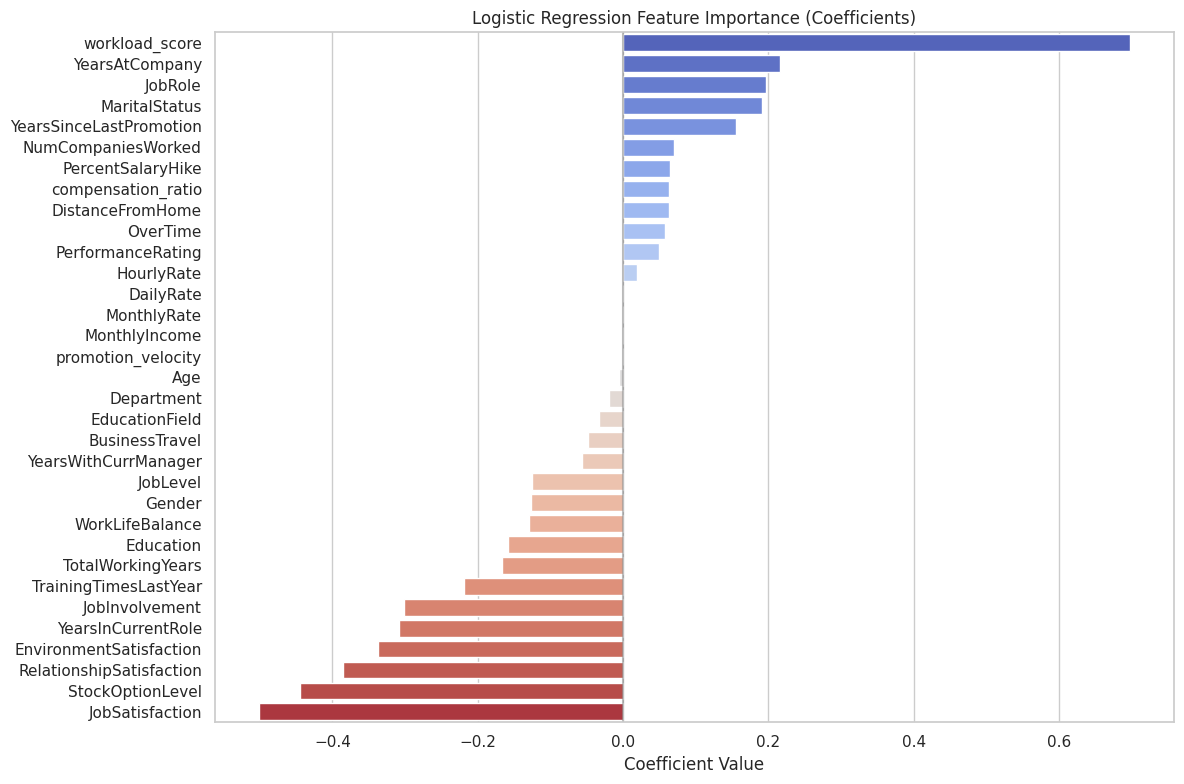

In [34]:
coef = pd.Series(model.coef_[0], index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=coef.values, y=coef.index, palette='coolwarm')
plt.title('Logistic Regression Feature Importance (Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('')
plt.axvline(0, color='gray', alpha=0.5)
plt.tight_layout()
plt.savefig('results/logistic_regression_feature_importance.png')
plt.show()
plt.close()

The coefficient plot ranks `workload_score` and `YearsAtCompany` as top positive influencers on "Attrition," while `JobSatisfaction` and `StockOptionLevel` are strong negative factors (bars at the end)

Features like `Age` has negligible impact

## Partial Dependence Plots

<Figure size 1500x500 with 0 Axes>

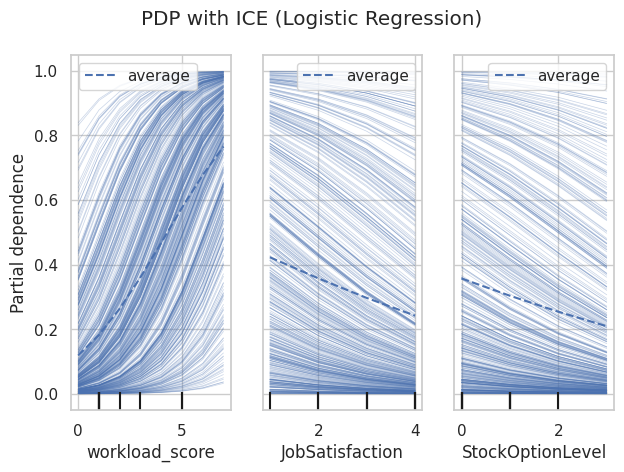

In [35]:
# I select the top 6 features based on the coeff of the model
top_features = coef.abs().sort_values(ascending=False).index[:3]

#PDPs with ICE lines
plt.figure(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(
    model, X_test, features=top_features, feature_names=X_train.columns,
    kind='both',
    grid_resolution=50
)
plt.suptitle('PDP with ICE (Logistic Regression)')
plt.tight_layout()
plt.savefig('results/logistic_regression_pdp.png')
plt.show()
plt.close()

The PDP with ICE  for `workload_score`, `JobSatisfaction`, and `StockOptionLevel` show increasing "Attrition" probability with higher `workload_score`, decreasing with higher `JobSatisfaction`, and slight decline with `StockOptionLevel` (0.3).

 ICE lines indicate individual variations

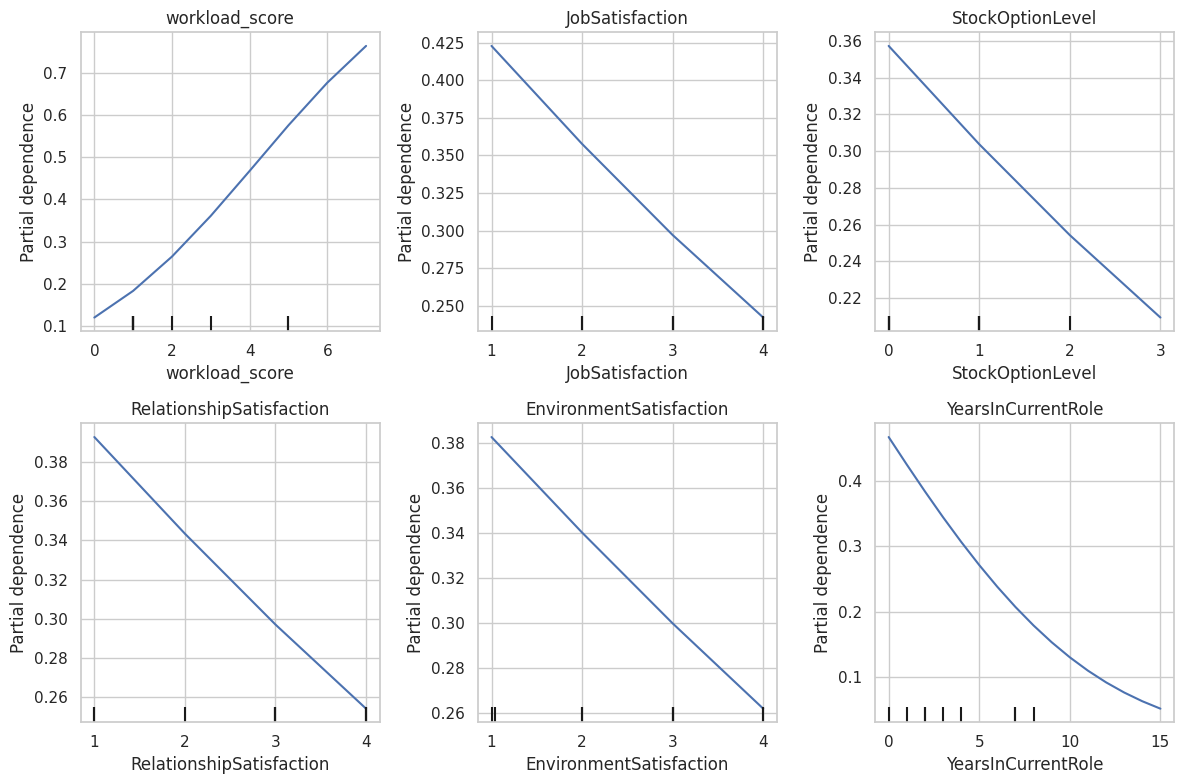

In [48]:
# Select top 6 features based on absolute coefficient values
coef = pd.Series(model.coef_[0], index=X_train.columns).abs().sort_values(ascending=False)
top_features = coef.index[:6].tolist()

if len(top_features) < 6:
    remaining_cols = [c for c in X_test.columns if c not in top_features and X_test[c].nunique() > 2]
    top_features.extend(remaining_cols[:6 - len(top_features)])

top_features = top_features[:6]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, feat in zip(axes, top_features):
    PartialDependenceDisplay.from_estimator(model, X_test, [feat], ax=ax)
    ax.set_title(feat)

for i in range(len(top_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('results/logistic_regression_pdp_6.png')
plt.show()
plt.close()

The 6 PDPs (`workload_score`, `JobSatisfaction`, `StockOptionLevel`, `RelationshipSatisfaction`, `EnvironmentSatisfaction`, `YearsInCurrentRole`) show `workload_score` increase "Attrition" probability with higher values, while `JobSatisfaction` and others decrease it

#**ICE**

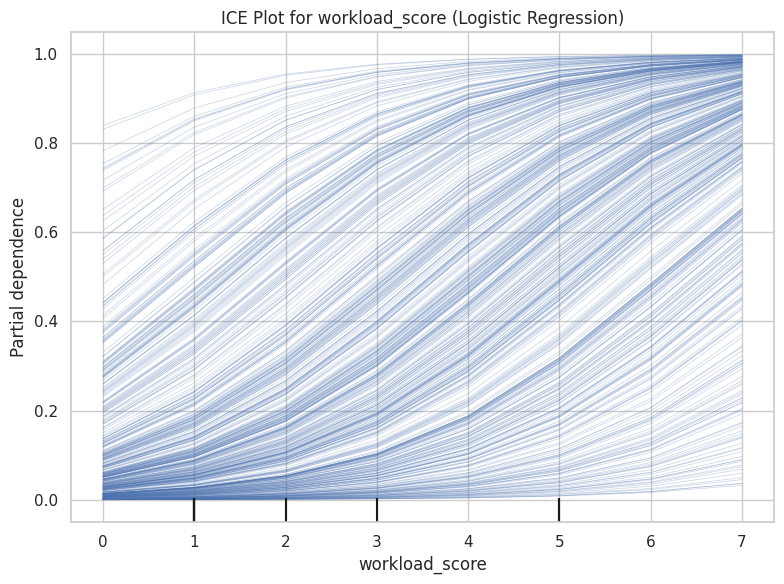

In [36]:
# ICE plot for the top feature

top_idx = X_train.columns.get_loc('workload_score')

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    model, X_test,
    features=[top_idx],
    kind="individual",
    ax=ax
)
plt.title("ICE Plot for workload_score (Logistic Regression)")
plt.tight_layout()
plt.savefig('results/logistic_regression_ice.png')
plt.show()


The ICE plot for `workload_score` shows a consistent upward trend in "Attrition" probability as scores increase, with individual lines converging, indicating a strong, uniform impact of workload on attrition risk.

##Permutation Feature Importance

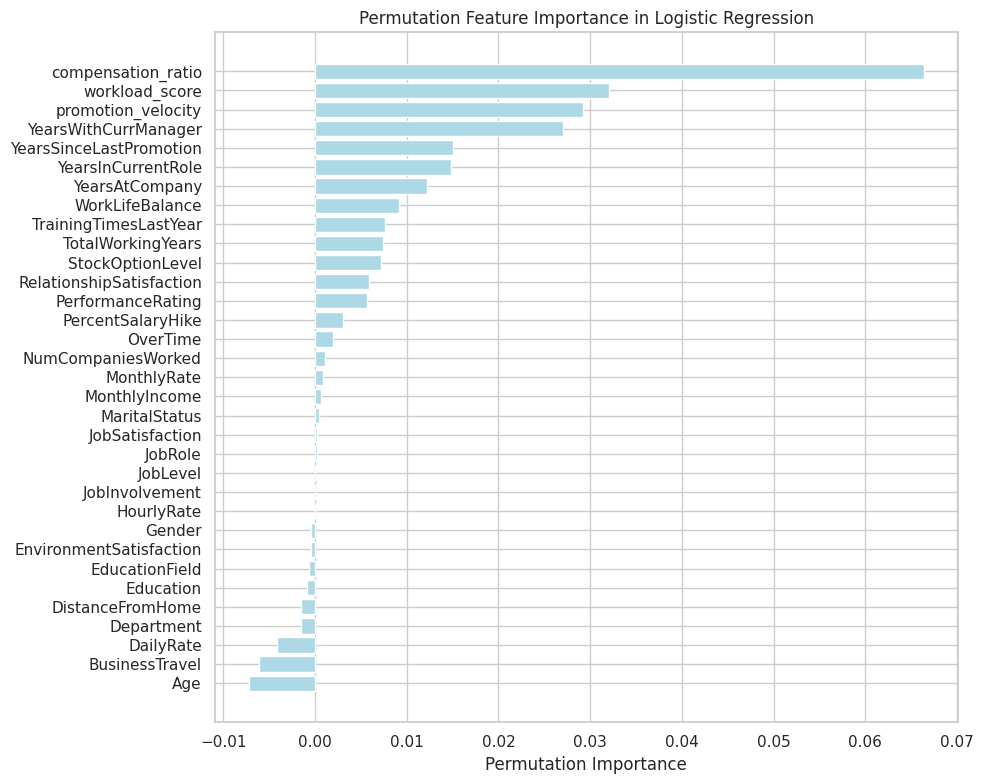

In [43]:
from sklearn.inspection import permutation_importance
plt.figure(figsize=(10, 8))

results = permutation_importance(model, X_test, y_test, n_repeats=10)
sorted_idx = results.importances_mean.argsort()

plt.barh(X_train.columns, results.importances_mean[sorted_idx], color='lightblue')
plt.xlabel("Permutation Importance")
plt.title('Permutation Feature Importance in Logistic Regression')
plt.tight_layout()
plt.savefig('results/logistic_regression_permutation_importance.png')
plt.show()

The plot demonatrates `compensation_ratio` as the most important feature (highest importance ~0.07), followed by `wokload_score` and `YearsInCurrentRole`. Features like `Age` and `BusinessTravel` have minimal impact.